In [4]:
# 1. Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

# 2. Load Dataset
df = pd.read_csv('/content/compas-scores-two-years.csv')

In [5]:
# 3. Feature Engineering
drop_cols = [
    'id', 'name', 'first', 'last', 'dob', 'compas_screening_date',
    'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_jail_in', 'c_jail_out',
    'r_case_number', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out',
    'vr_case_number', 'vr_offense_date', 'vr_charge_desc', 'screening_date',
    'v_screening_date', 'in_custody', 'out_custody', 'start', 'end',
    'violent_recid', 'decile_score.1', 'priors_count.1'
]

df = df.drop(columns=drop_cols)

# Hapus baris yang missing pada kolom penting
df = df.dropna(subset=['age', 'race', 'sex', 'priors_count', 'c_charge_degree', 'is_recid'])

# Encode data kategorikal
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

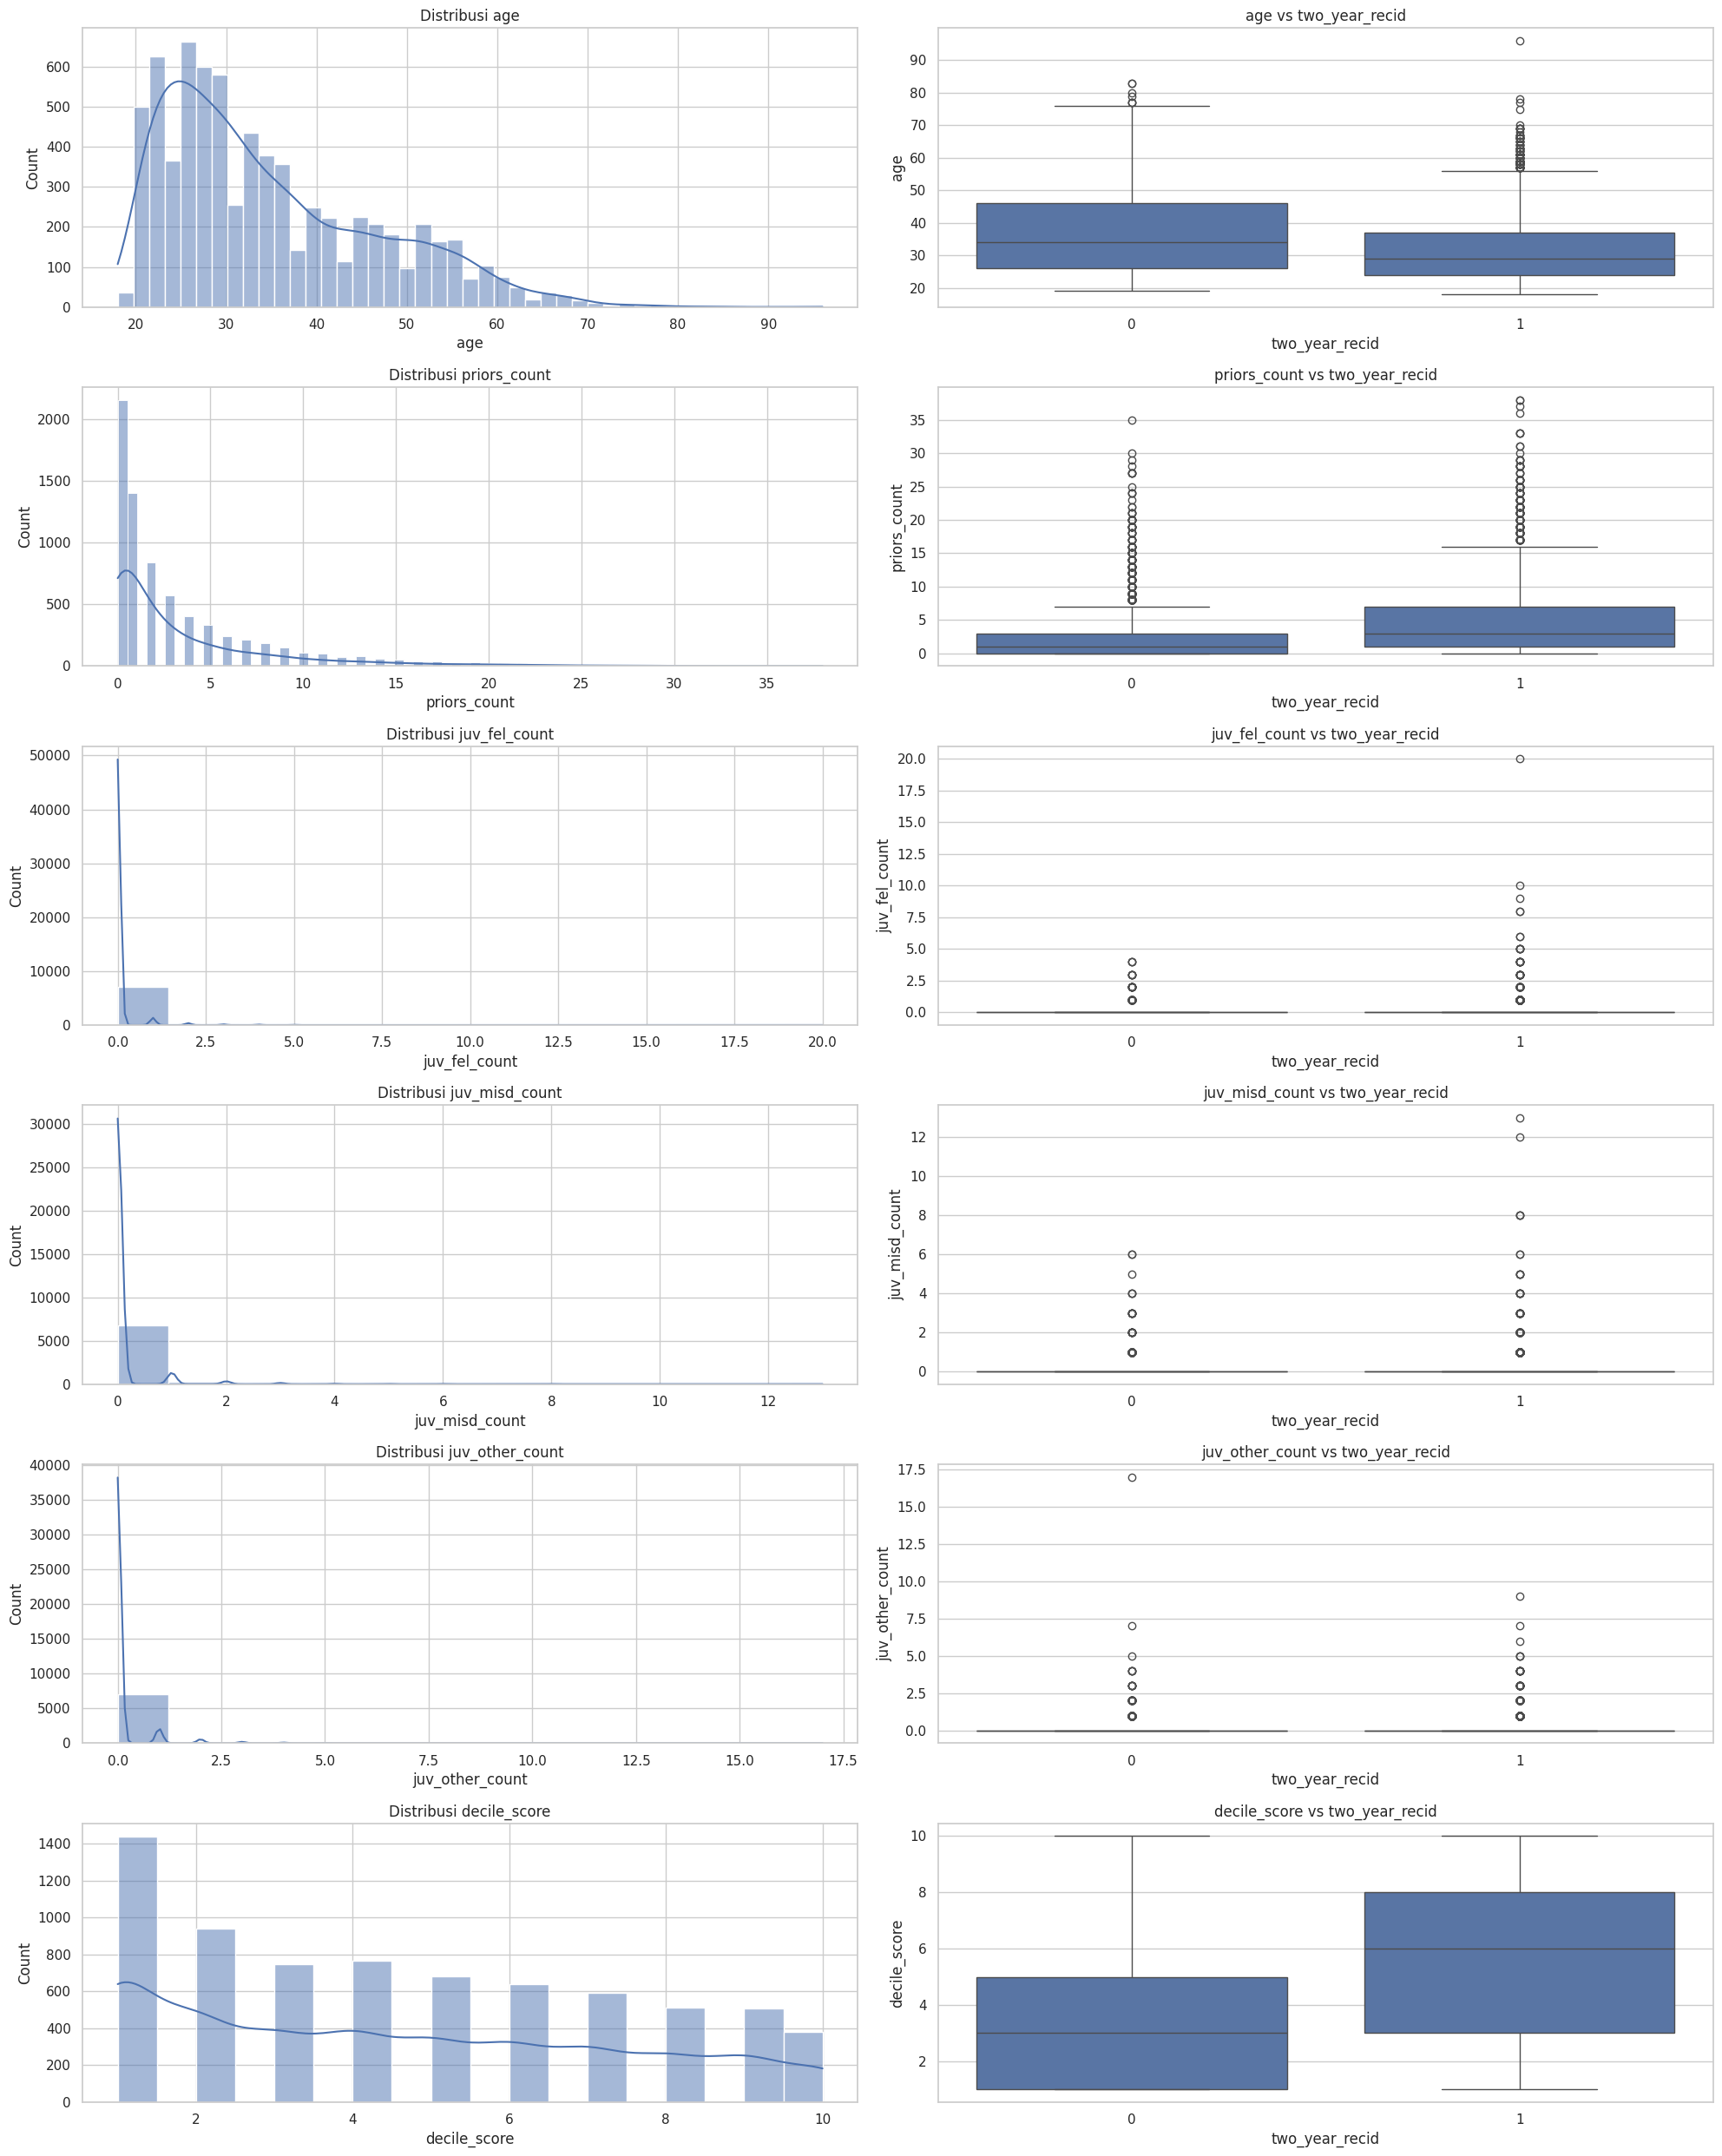

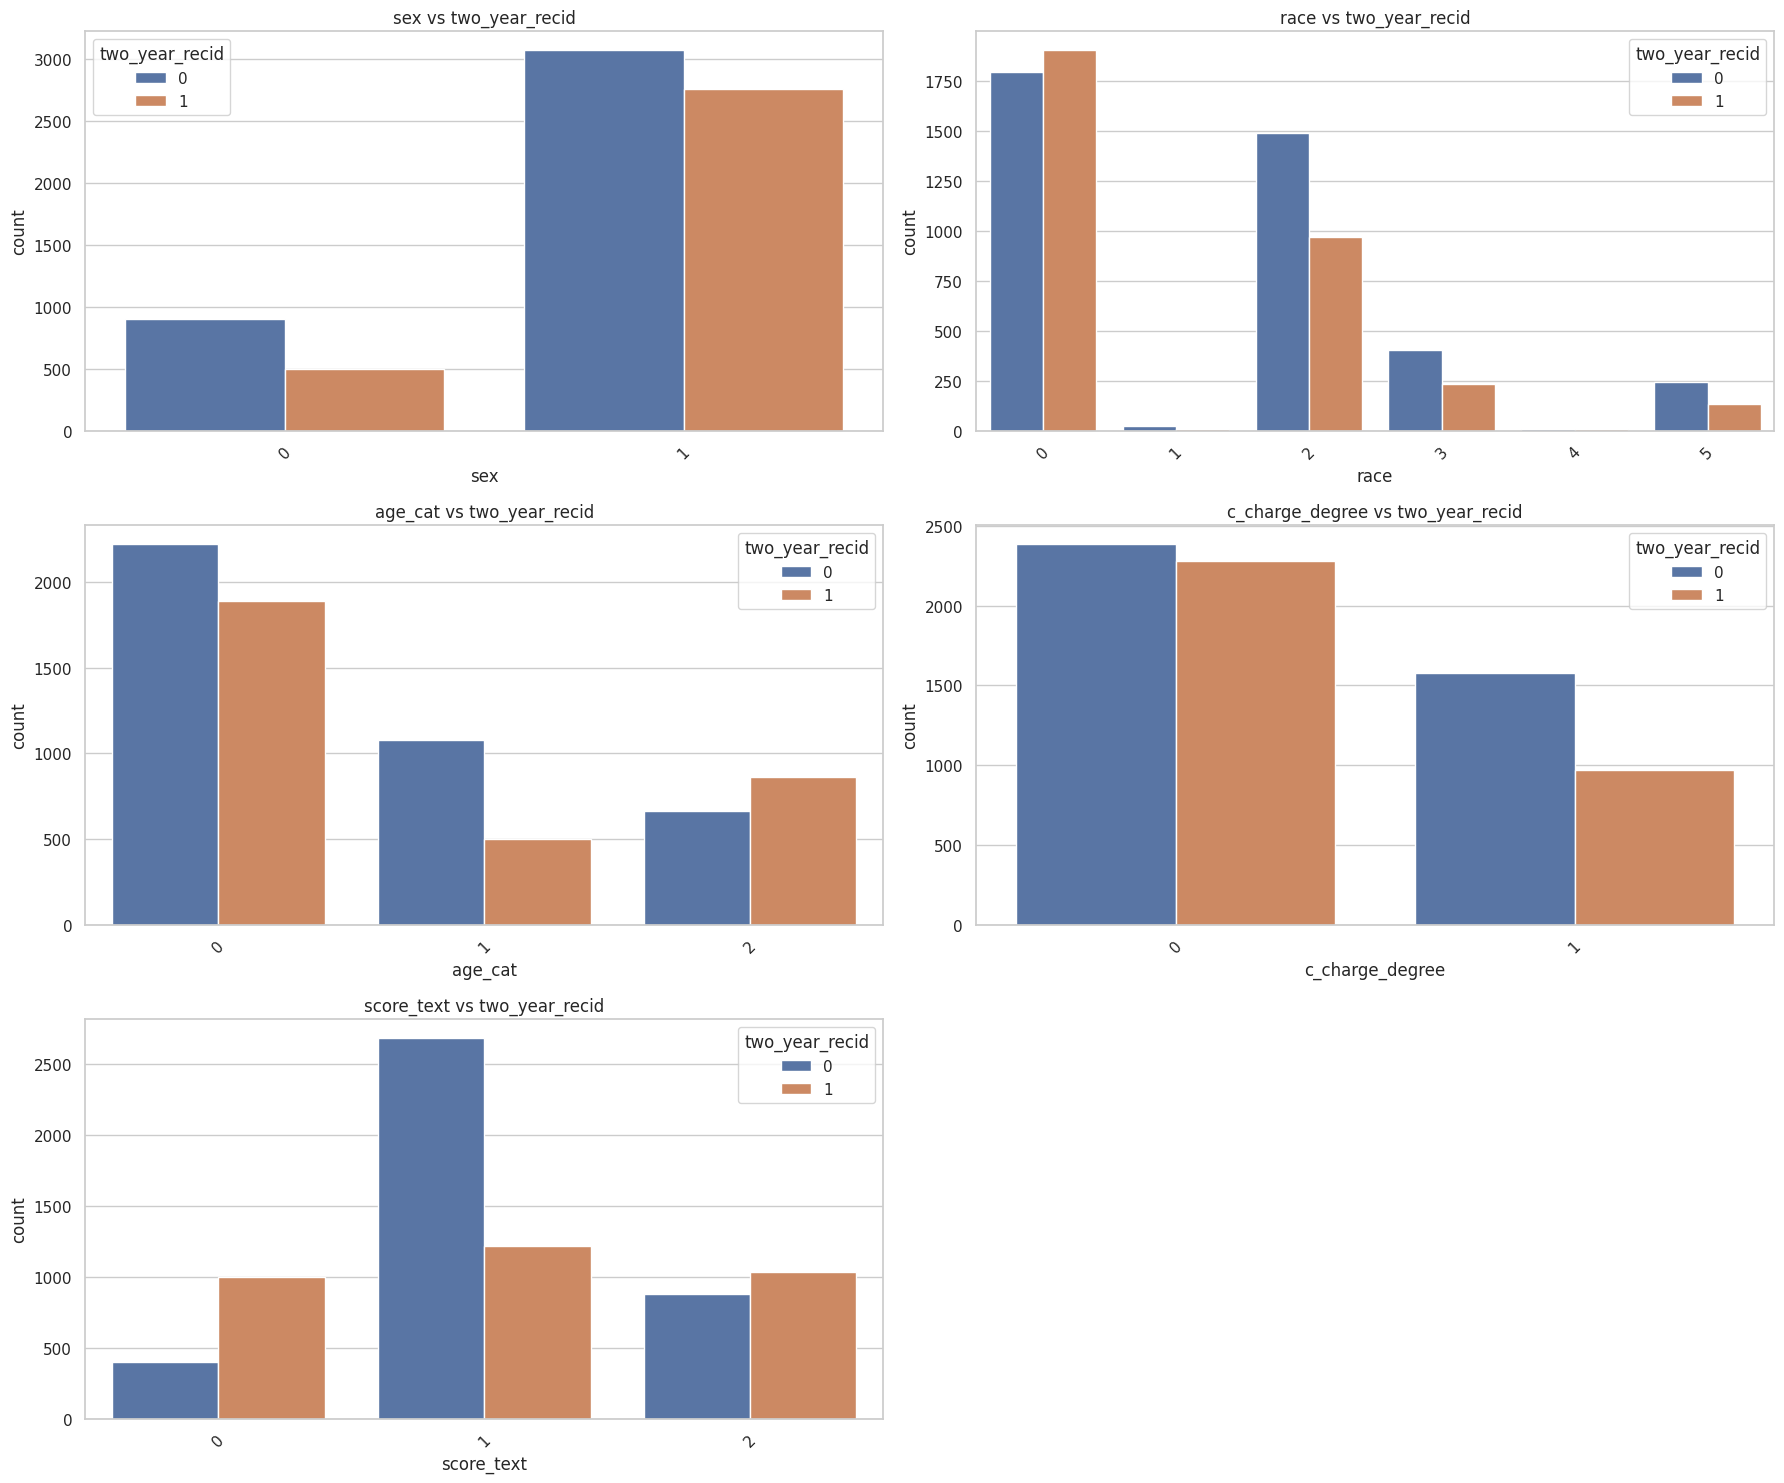

In [6]:
# 4. EDA dan Visualisasi
sns.set(style="whitegrid")
plt.figure(figsize=(20, 25))
num_features = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'decile_score']

for i, col in enumerate(num_features):
    plt.subplot(6, 2, 2 * i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribusi {col}')

    plt.subplot(6, 2, 2 * i + 2)
    sns.boxplot(x='two_year_recid', y=col, data=df)
    plt.title(f'{col} vs two_year_recid')

plt.tight_layout()
plt.show()

cat_features = ['sex', 'race', 'age_cat', 'c_charge_degree', 'score_text']
plt.figure(figsize=(18, 15))

for i, col in enumerate(cat_features):
    plt.subplot(3, 2, i + 1)
    sns.countplot(x=col, hue='two_year_recid', data=df)
    plt.title(f'{col} vs two_year_recid')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [7]:
# 5. Split Dataset
X = df.drop(columns=['two_year_recid'])
y = df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
# 6. Imputasi & Scaling Fitur Numerik
num_cols = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'decile_score']
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train[num_cols] = imputer.fit_transform(X_train[num_cols])
X_test[num_cols] = imputer.transform(X_test[num_cols])

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


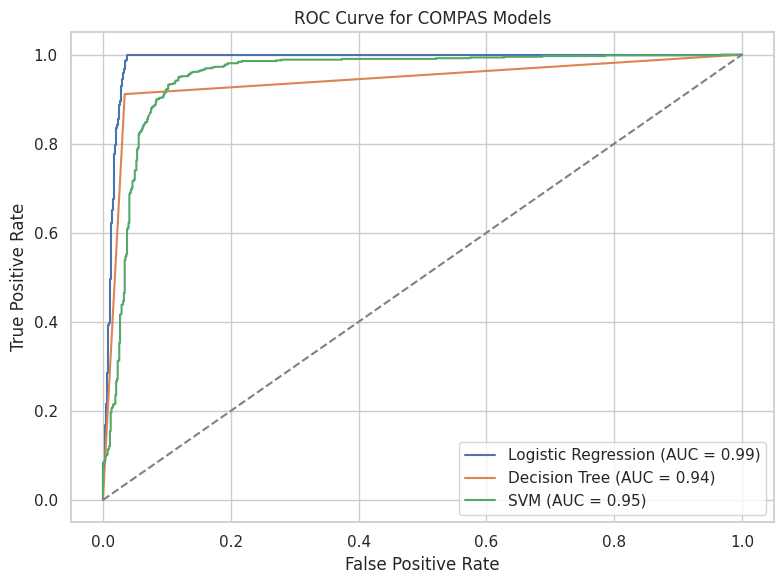

In [9]:
# 7. Modeling
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True)
}

results = []
plt.figure(figsize=(8, 6))

# Imputasi seluruh dataset X (numerik & non-numerik) sebelum modeling
imputer_all = SimpleImputer(strategy='most_frequent')
X_train = pd.DataFrame(imputer_all.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer_all.transform(X_test), columns=X_test.columns)


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba)
    })

    # Plot ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for COMPAS Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# 8. Hasil Evaluasi
eval_df = pd.DataFrame(results)
print("Evaluasi Model COMPAS:\n")
print(eval_df)


Evaluasi Model COMPAS:

                 Model  Accuracy  Precision    Recall  F1-Score       AUC
0  Logistic Regression  0.977131   0.950845  0.998387  0.974036  0.987026
1        Decision Tree  0.942481   0.952782  0.911290  0.931575  0.938634
2                  SVM  0.634789   0.911504  0.166129  0.281037  0.952185
